<a href="https://colab.research.google.com/github/Victorrani/synoptic_maps/blob/main/gfs025_testes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Creating maps based on (copies of) the website https://www.atmos.albany.edu/student/abentley/realtime.html
###just for training

###Installing the necessary libraries for the maps.
###Need to observe possible version errors

In [ ]:
##instalar as biblitecas
!pip install pygrib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install numpy==1.23

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.0
    Uninstalling numpy-1.25.0:
      Successfully uninstalled numpy-1.25.0


In [ ]:
!pip install cartopy
!pip install shapely --no-binary shapely --force

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached shapely-2.0.1-cp310-cp310-linux_x86_64.whl
  Using cached numpy-1.25.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.0
    Uninstalling numpy-1.23.0:
      Successfully uninstalled numpy-1.23.0
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.1
    Uninstalling shapely-2.0.1:
      Successfully uninstalled shapely-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.0 whi

In [ ]:
!pip install metpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###All libraries used in the script

In [ ]:
import sys
import pygrib
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import pandas as pd
from metpy.calc import reduce_point_density
from metpy.io import metar
from metpy.plots import current_weather, sky_cover, StationPlot
import metpy.plots as mpplots
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from google.colab import drive
import metpy.calc as mpcalc
from metpy.units import units

###File in grib2 format stored on googledrive

In [48]:
##open file

drive.mount('/content/drive')

arquivo = '/content/drive/MyDrive/gfs025.202304200000_000.grb2'

gfs = pygrib.open(arquivo)
gfs

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Download the file of the states of Brazil

In [ ]:
!wget -c https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
!unzip -o br_unidades_da_federacao.zip

--2023-06-21 16:54:44--  https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10912177 (10M) [application/zip]
Saving to: ‘br_unidades_da_federacao.zip’

br_unidades_da_fede 100%[===================>]  10.41M  8.31MB/s    in 1.3s    

2023-06-21 16:54:46 (8.31 MB/s) - ‘br_unidades_da_federacao.zip’ saved [10912177/10912177]

Archive:  br_unidades_da_federacao.zip
 extracting: BR_UF_2019.cpg          
  inflating: BR_UF_2019.dbf          
  inflating: BR_UF_2019.prj          
  inflating: BR_UF_2019.shp          
  inflating: BR_UF_2019.shx          


###Selecting region of Brazil on the Map. A next version can be chosen anywhere in the world

In [49]:
regiao = [-120, 0, -60, 15]

### PLOT 1

In [50]:
titulo = 'MSLP (black, hPa), 1000 - 500 thickness (red/blue, dam), 250 hPa wind speedy (shaded, m/s)\nGFS 0.25 2023/04/02 00Z'

In [51]:
##select variables

select_u250 = gfs.select(name='U component of wind', typeOfLevel='isobaricInhPa', level=250)[0]
select_v250 = gfs.select(name='V component of wind', typeOfLevel='isobaricInhPa', level=250)[0]

u250, lats, lons = select_u250.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)
v250, lats, lons = select_v250.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)

select_geo500=gfs.select(name='Geopotential Height', typeOfLevel = 'isobaricInhPa', level = 500)[0]
select_geo1000=gfs.select(name='Geopotential Height', typeOfLevel='isobaricInhPa', level=1000)[0]

geo500, lats, lons = select_geo500.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)
geo1000, lats, lons = select_geo1000.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)

select_pmsl=gfs.select(name='Pressure reduced to MSL')[0]
pmsl, lats, lons = select_pmsl.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)

#deal with the variables
pmsl = pmsl / 100
deltageo = (geo500 - geo1000) / 10
mag250 = np.sqrt((u250*u250)+(v250*v250))





In [52]:
##função que trata o dado suaviza a onda

pmsl = ndimage.gaussian_filter(pmsl, sigma=5, order=0)
mag250 = ndimage.gaussian_filter(mag250, sigma=5, order=0)
deltageo = ndimage.gaussian_filter(deltageo, sigma=5, order=0)

In [54]:
##Create colormap

colors = [(1, 1, 1), (0, 0, 1), (1, 0, 0), (1, 1, 1)]
cmap_name = 'custom_blue_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

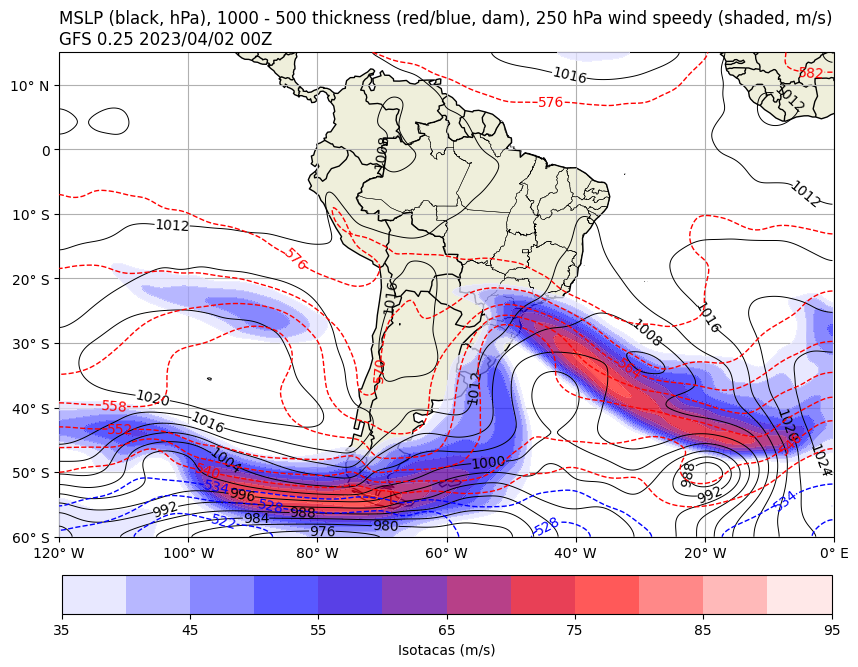

In [56]:
fig = plt.figure(figsize=(10,10))

##Criação do mapa com o projeção
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(regiao, crs=ccrs.PlateCarree())

##Funcionalidades do mapa
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

##Coloca os estados brasileiros no mapa
shapefile = list(shpreader.Reader('BR_UF_2019.shp').geometries())
ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black',facecolor='none', linewidth=0.3, zorder=300)


##Jatos de altos níveis
data_min = 35
data_max = 100
interval = 5
levels = np.arange(data_min,data_max,interval)


img1 = ax.contourf(lons, lats, mag250,cmap=cm, levels=levels,vmin=35,  transform=ccrs.PlateCarree(), zorder=300, alpha=0.75)
img2 = ax.contour(lons, lats, mag250, colors='white', linewidths=0.2, levels=levels, transform=ccrs.PlateCarree(), zorder=301)
plt.colorbar(img1, label='Isotacas (m/s)', orientation='horizontal', pad=0.05, fraction=0.05)

##pmsl
data_min_pmsl = 840
data_max_pmsl = 1200
interval_pmsl = 4
levels_pmsl = np.arange(data_min_pmsl, data_max_pmsl,interval_pmsl)


img3 = ax.contour(lons, lats, pmsl, colors='black', linewidths=0.7, levels=levels_geo, zorder=305)
ax.clabel(img3, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors= 'black')

##espessura da camada <540dam
data_min_espessura = 0
data_max_espessura = 540
interval_espessura = 6
levels = np.arange(data_min_espessura ,data_max_espessura ,interval_espessura)


img4 = ax.contour(lons, lats, deltageo, colors='blue', linestyles='dashed', linewidths=1, levels=levels, zorder=306)
ax.clabel(img4, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors= 'blue')

##espessura da camada >540dam
data_min_espessura2 = 540
data_max_espessura2 = 1000
interval_espessura2 = 6
levels = np.arange(data_min_espessura2,data_max_espessura2,interval_espessura2)


img5 = ax.contour(lons, lats, deltageo, colors='red', linestyles='dashed', linewidths=1, levels=levels, zorder=307)
ax.clabel(img5, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors='red')


##Cria os marcadores das latitudes e longitudes
x_min, x_max = regiao[0], regiao[1]
y_min, y_max = regiao[2], regiao[3]

x_ticks = np.arange(x_min, x_max + 1, 20)
y_ticks = np.arange(y_min, y_max + 1, 10)

y_ticklabels = [f'{abs(tick)}° S' if tick < 0 else f'{tick}° N' if tick > 0 else '0' for tick in y_ticks]
x_ticklabels = [f'{abs(tick)}° W' if tick < 0 else f'{tick}° E' for tick in x_ticks]

ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.set_xticklabels(x_ticklabels)
ax.set_yticklabels(y_ticklabels)

ax.grid()

plt.title(titulo, loc='left')

plt.show()

### PLOT 2

In [ ]:
titulo = '500 hPa geo height (black, dam), Temp (red, C)\nGFS 0.25 2023/04/02 00Z'

select_u500=gfs.select()[355]
select_v500=gfs.select()[356]
select_geo500=gfs.select()[348]
select_temp500=gfs.select()[349]
select_ascent500=gfs.select()[353]
select_vortice500=gfs.select()[357]


u500, lats, lons = select_u500.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)
v500, lats, lons = select_v500.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)
geo500, lats, lons = select_geo500.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)
temp500, lats, lons = select_temp500.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)
ascent500, lats, lons = select_ascent500.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)
vortice500, lats, lons = select_vortice500.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)

temp500 = temp500 - 273
geo500 = geo500 / 10
ascent500 = ( ascent500 / 100 )
mag500 = np.sqrt((u500*u500)+(v500*v500))


	##cria o contorno das linhas arredondado, suavizado
geo500 = ndimage.gaussian_filter(geo500, sigma=5, order=0)
mag500 = ndimage.gaussian_filter(mag500, sigma=5, order=0)
temp500 = ndimage.gaussian_filter(temp500, sigma=5, order=0)

In [ ]:
u500 = units('m/s')*u500
v500 = units('m/s')*v500
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
vortice_500 = mpcalc.vorticity(u500,v500, dx=dx, dy=dy)


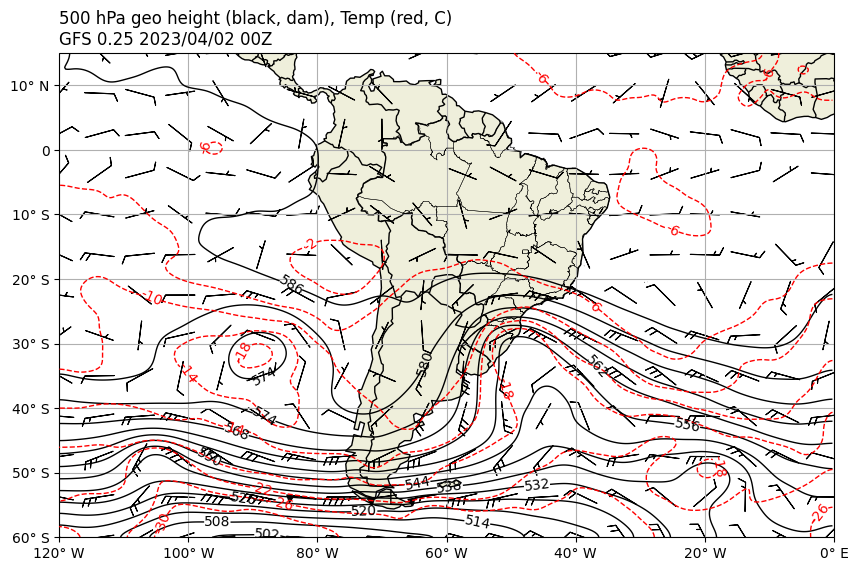

In [ ]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(regiao, crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

shapefile = list(shpreader.Reader('BR_UF_2019.shp').geometries())
ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black',facecolor='none', linewidth=0.3, zorder=300)


data_min_geo = 400
data_max_geo = 700
interval_geo = 6
levels_geo = np.arange(data_min_geo ,data_max_geo ,interval_geo)

##Plot the geopotencial height
img1 = ax.contour(lons, lats, geo500, colors='black', linewidths=1, levels=levels_geo, zorder=305)
ax.clabel(img1, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors= 'black')

data_min_temp = -50
data_max_temp = 0
interval_temp = 4
levels_temp = np.arange(data_min_temp, data_max_temp, interval_temp)

##temperatura
img2 = ax.contour(lons, lats, temp500, colors='red', linewidths=1, levels=levels_temp, zorder=306)
ax.clabel(img2, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors= 'red')

##wind_barbs

# Create a flag to determine which barbs are flipped
flip_flag = np.zeros((u500.shape[0],v500.shape[1]))

# All flags below the equator will be flipped
flip_flag[lats < 0] = 1

img3 = ax.barbs(lons[::25,::25],
                lats[::25,::25],
                u500[::25,::25],
                v500[::25,::25],
                sizes=dict(emptybarb=0.0, spacing=0.2, height=0.25),
                linewidth=0.8,
                length=6.5,
                pivot='middle',
                barbcolor='black',
                flip_barb = flip_flag[::25,::25])

##plot rel vort
#data_min_vort = 60
#data_max_vort = 0
#interval_vort = 15
#levels_vort = np.arange(data_min_vort, data_max_vort, interval_vort)

#img4 = ax.contourf(lons, lats, vortice_500*10**5, cmap='YlOrRd_r', vmax=0, vmin=-60)
#plt.colorbar(img4, label='Vorticidade (1/s)', orientation='horizontal', pad=0.05, fraction=0.05)

##plot vertical speedy
#data_min_ascent = -0.08
#data_max_ascent = 0
#interval_ascent = 0.02
#levels_ascent = np.arange(data_min_ascent, data_max_ascent, interval_ascent)

#img4 = ax.contourf(lons, lats, ascent500, colors='blue', levels=levels_ascent)
#img5 = ax.contourf(lons, lats, ascent500, colors='blue',levels=levels_ascent, vmax=0, vmin=-0.005)


##definindo as variáveis colocar as lats e lons com respectivo N, S, E, W
x_min, x_max = regiao[0], regiao[1]
y_min, y_max = regiao[2], regiao[3]
##Define de onde até onde a marcação vai com passos definidos
x_ticks = np.arange(x_min, x_max + 1, 20)
y_ticks = np.arange(y_min, y_max + 1, 10)
##condição
y_ticklabels = [f'{abs(tick)}° S' if tick < 0 else f'{tick}° N' if tick > 0 else '0' for tick in y_ticks]
x_ticklabels = [f'{abs(tick)}° W' if tick < 0 else f'{tick}° E' for tick in x_ticks]

ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.set_xticklabels(x_ticklabels)
ax.set_yticklabels(y_ticklabels)

ax.grid()

plt.title(titulo, loc='left')

plt.show()